In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sto_density import *
from scipy.fftpack import fft 
from tqdm import tqdm

In [16]:
kappa = 1
n = 8
tau = 8.6*2
epsilon = 8.6/2
mu = 1.2
nu = 1.2

T = 5e3
dt = 1e-2
sigma = 1e-3
n_batches = int(T)

N = 40

epsilons = np.linspace(2, 10, N)
taus = np.linspace(10, 30, N)

### Parameter sweep (don't run this part -- just run the part that loads the saved data)

In [17]:
freqs = np.empty((N, N))
amps = np.empty((N, N))



for (i, epsilon) in tqdm(enumerate(epsilons)): 
    for (j, tau) in enumerate(taus):
        m = density_field_model(mu, nu, kappa, n, tau, epsilon)
        m.initialise(T, dt, n_batches, 1.2, sigma)
        m.evolve() 
        
        y = np.copy(m.psi[-200:]).flatten() 
        y_k = np.abs(np.fft.rfft(y)[1:])
        
        freqs[i, j] = y_k.argmax()
        amps[i, j] = y_k.max() 

40it [16:39, 25.00s/it]


In [18]:
np.save('Sims/freqs.npy', freqs)
np.save('Sims/amps.npy', amps)

In [14]:
freqs = np.load('Sims/freqs.npy')
amps = np.load('Sims/amps.npy')

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_30796/3050813434.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


0.20660343464697176 1.2059919300903963


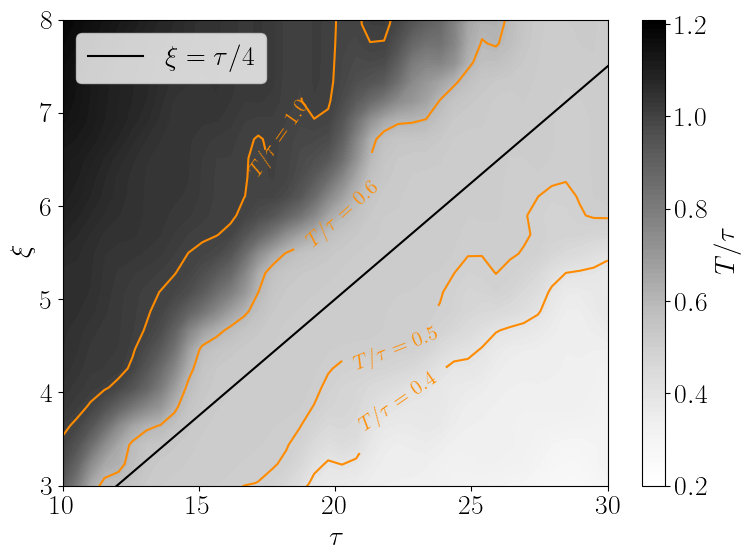

In [23]:
from scipy.ndimage.filters import gaussian_filter

image = (200/(freqs+1)/taus[np.newaxis, :])[1:-1, :]
image = gaussian_filter(image, 1)
vmin = np.amin(image)
vmax = np.amax(image)
print(vmin, vmax)

plt.rc('font', size=20)
plt.rc('text', usetex=True)

plt.figure(figsize=(8, 6))

plt.contourf(taus, epsilons[1:-1], image, vmin=vmin, vmax=vmax, cmap='Greys', levels=100)
plt.colorbar(ticks=[0.2, 0.4, 0.6, 0.8, 1, 1.2], label=r'$T/\tau$') 
CS = plt.contour(taus, epsilons[1:-1], image, levels=[0.4, 0.5, 0.6, 1], colors='darkorange')
plt.clabel(CS, fmt=lambda x: r'$T/\tau = {}$'.format(x), fontsize=15)

plt.plot(taus, taus*0.25, label=r'$\xi = \tau/4 $', c='k')
# plt.fill_between(taus, taus*0.25, taus*0.5, hatch='///', facecolor='None', label=r'$\tau/4 < \xi < \tau / 2$')
plt.legend(loc='upper left')
plt.xlim([10, 30])
plt.ylim([3, 8])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\xi$')
plt.tight_layout()
plt.savefig('Figures/period.pdf')
plt.show() 

### Plot graphs at the biologically relevant parameters

In [14]:
tau = 8.6*2
epsilon = 8.6/2
sigma = 1e-3
mu = 1.2
nu = 1.2
kappa = 1
n = 8
T = 1e3
dt = 1e-2
n_frames = int(T*5)
m = density_field_model(mu, nu, kappa, n, tau, epsilon)
m.initialise(T, dt, n_frames, 1.2, sigma)
m.evolve(True) 

time taken:  0.14148402214050293


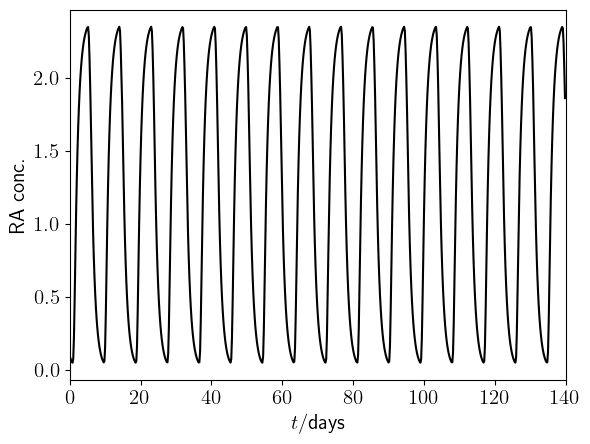

In [15]:
start = 1800
stop = 2500

t = np.arange(0, (stop-start)*0.2, 0.2)
plt.rc('font', size=15)
plt.rc('text', usetex=True)
plt.plot(t, m.psi[start:stop],'k')
plt.xlim([0, (stop-start)*0.2])
plt.xlabel(r'$t$/days')
plt.ylabel('RA conc.')
plt.savefig('Figures/ra.pdf')
plt.show() 

### Run simulations with different initial conditions

time taken:  0.12424397468566895
time taken:  0.12423110008239746
time taken:  0.1305379867553711


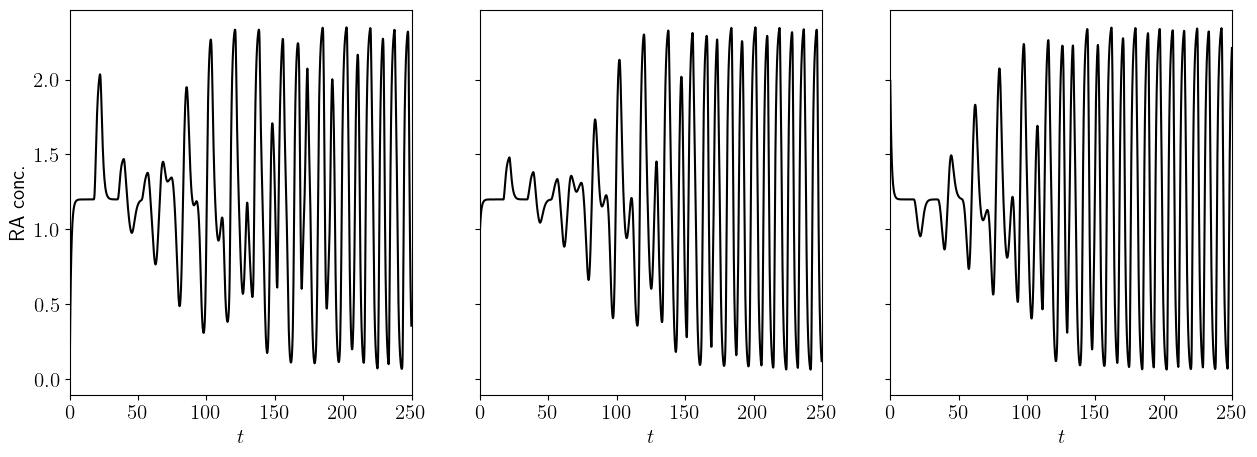

In [20]:
tau = 8.6*2
epsilon = 8.6/2
sigma = 1e-3
mu = 1.2
nu = 1.2
kappa = 1
n = 6
T = 250
dt = 1e-2
n_frames = int(T*5)

start = 0
stop = 2000

plt.rc('font', size=15)
plt.rc('text', usetex=True)

fig, axes = plt.subplots(1, 3,figsize=(15, 5), sharex=True, sharey=True)

for (i, psi0) in enumerate([0, 1, 2]):
    
    m = density_field_model(mu, nu, kappa, n, tau, epsilon)
    m.initialise(T, dt, n_frames, psi0, sigma)
    m.evolve(True) 

    t = np.arange(0, T, 0.2)
    axes[i].plot(t, m.psi, color='k')
    axes[i].set_xlabel(r'$t$')
axes[0].set_xlim([0, T])
axes[0].set_ylabel('RA conc.')
plt.savefig('Figures/ra_multiple_inits.pdf')
plt.show()

### Run simulations with RA pulses with different periods. Pulses are defined as modifying RA production rate.

time taken:  0.15463614463806152
time taken:  0.1544349193572998
time taken:  0.17360401153564453
time taken:  0.14798212051391602


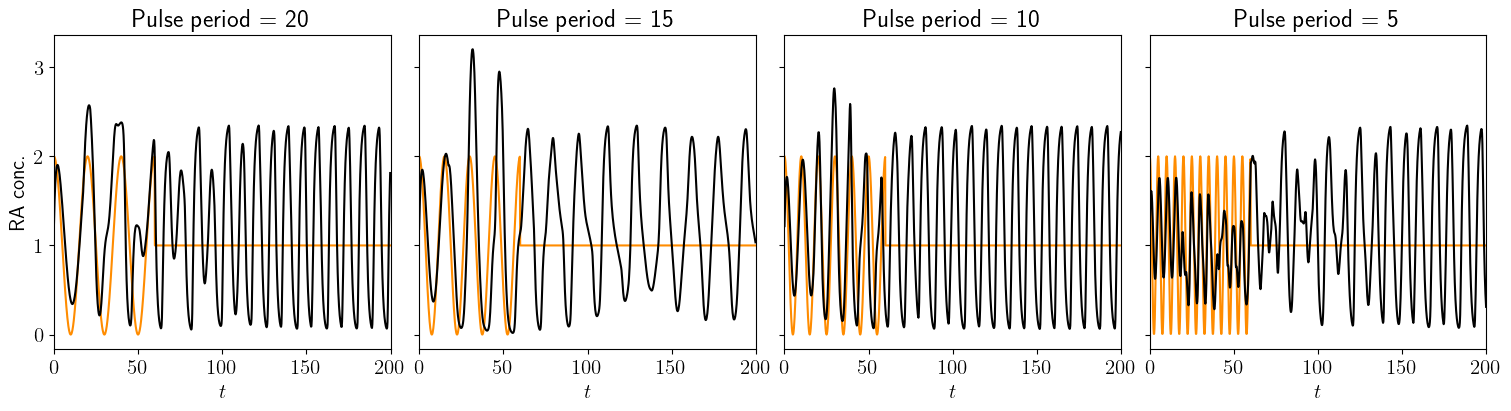

In [33]:
tau = 8.6*2
epsilon = 8.6/2
sigma = 1e-2
mu = 1.2
nu = 1.2
kappa = 1
n = 6
T = 200
dt = 1e-2
n_frames = int(T*5)
psi0=1.2

pulse_time = 60
pulse_periods = [20, 15, 10, 5]

plt.rc('font', size=15)
plt.rc('text', usetex=True)
fig, axes = plt.subplots(1, len(pulse_periods),figsize=(15, 4), sharex=True, sharey=True, constrained_layout=True)
for (i, pulse_period) in enumerate(pulse_periods):
    pulses = lambda t: 1+np.heaviside(pulse_time-t, 0)*(np.cos(t*2*np.pi/pulse_period))
    
    m = density_field_model(mu, nu, kappa, n, tau, epsilon)
    m.initialise(T, dt, n_frames, psi0, sigma, pulses)
    m.evolve(True) 

    t = np.arange(0, T, 0.2)
    axes[i].plot(t, pulses(t), color='darkorange')
    axes[i].plot(t, m.psi, color='k')
    axes[i].set_title('Pulse period = {}'.format(pulse_period))
    axes[i].set_xlabel(r'$t$')
    
axes[0].set_xlim([0, T])
axes[0].set_ylabel('RA conc.')
plt.savefig('Figures/ra_pulse_inits.pdf')
plt.show()

### Alternative time delaying model (just ignore this part)

In [9]:
n = 4
tau = 10
mu = 5/tau
nu = 5/tau
kappa = 1


T = 5e2
dt = 1e-2
sigma = 0
n_batches = int(T)


m = aging_model(mu, nu, kappa, n, tau)
m.initialise(T, dt, n_batches, sigma)
m.evolve() 

time taken:  2.148705005645752


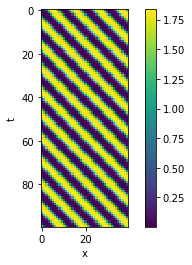

In [10]:
plt.imshow(m.psi[-100:, ::100])
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar() 
plt.show() 